# Credit Premia Cross-Asset Equity Premia (pure returns)

This notebook will look into the use of credit risk premia as a signal return for equity risk premia

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
import sys
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CreditEquityPremia\root\src")
from SignalGenerator import SignalResid

# Data Prep

In [3]:
def get_backtest() -> pd.DataFrame: 
    
    df_is = (SignalResid().get_is_resid()[
        ["credit_premia", "eq_premia", "date", "signal_rtn"]].
        assign(sample_group = "in_sample"))

    df_oos = (SignalResid().get_oos_resid()[
        ["credit_premia", "eq_premia", "date", "signal_rtn"]].
        assign(sample_group = "out_sample"))

    df_sample = (SignalResid().get_min_max_median_sampled_rtn()[
        ["credit_premia", "eq_premia", "date", "sharpe_group", "signal_rtn"]].
        rename(columns = {"sharpe_group": "sample_group"}).
        assign(sample_group = lambda x: "sampled_" + x.sample_group))

    df_out = (pd.concat([
        df_is, df_oos, df_sample]))
    
    return df_out

df_backtest = get_backtest()

In [4]:
def prep_plot_backtest(df_backtest: pd.DataFrame) -> pd.DataFrame: 
    
    replacer = {
        "in_sample"            : "In Sample",
        "out_sample"           : "Out of Sample",
        "sampled_max_sharpe"   : "Sampled\nMax Sharpe",
        "sampled_min_sharpe"   : "Sampled\nMin Sharpe",
        "sampled_median_sharpe": "Sampled\nMedian Sharpe"}

    df_prep = (df_backtest.assign(
        credit_premia = lambda x: np.where(x.credit_premia == "fa_premia", "Fallen Angel Premia", "High Yield Premia"),
        eq_premia     = lambda x: np.where(x.eq_premia == "IWB", "Rusell 1000", "Russell 3000"),
        group_var     = lambda x: x.credit_premia + "\n" + x.eq_premia).
        replace(replacer))
    
    return df_prep

df_plot = prep_plot_backtest(df_backtest)

# Returns Correlation

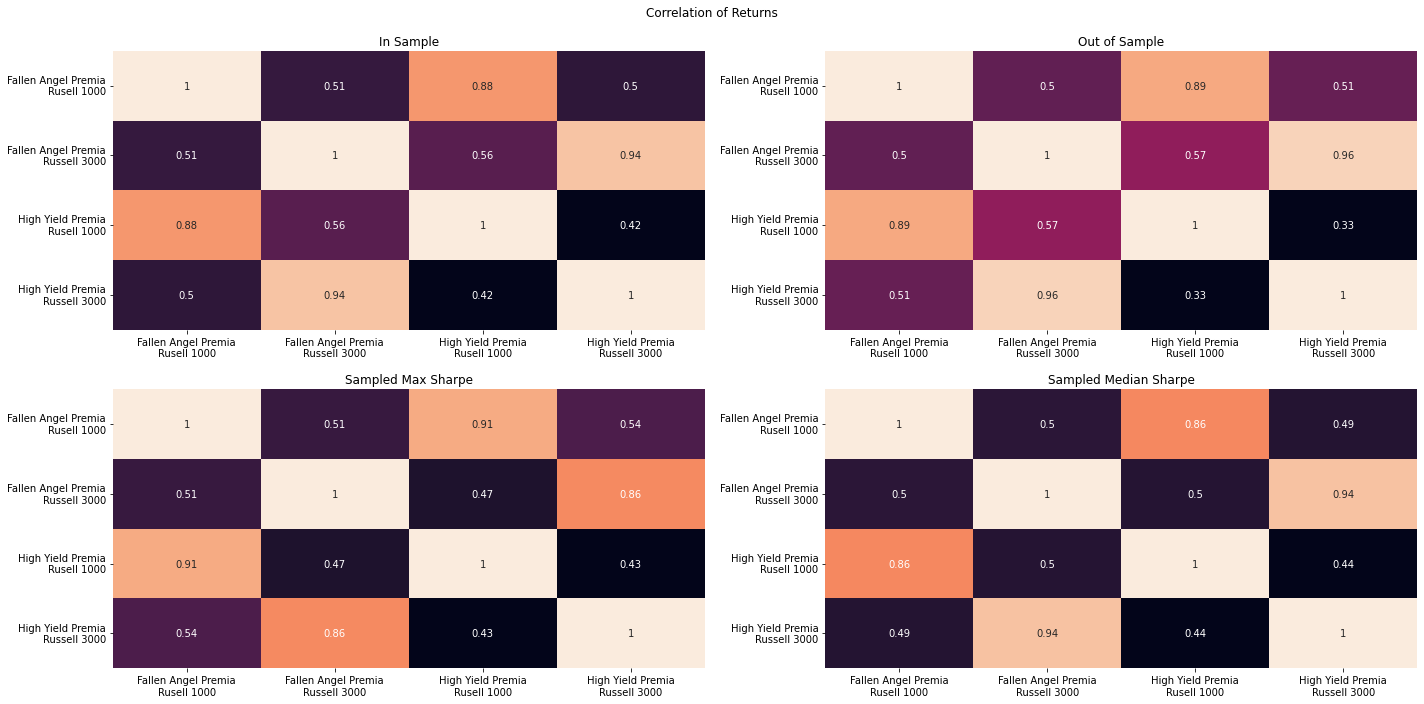

In [5]:
def plot_correlation(df_plot: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_plot.sample_group.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,10))

    for sample_group, ax in zip(group_vars, axes.flatten()):

        df_corr = (df_plot.query(
            "sample_group == @sample_group").
            pivot(index = "date", columns = "group_var", values = "signal_rtn").
            corr())

        sns.heatmap(
            ax    = ax, 
            data  = df_corr, 
            annot = True, 
            cbar  = False)

        ax.set_title(sample_group.replace("\n", " "))
        ax.set_xlabel("")
        ax.set_ylabel("")

    fig.suptitle("Correlation of Returns")
    plt.tight_layout(pad = 1.5)
    
plot_correlation(df_plot)

# Backtested Returns

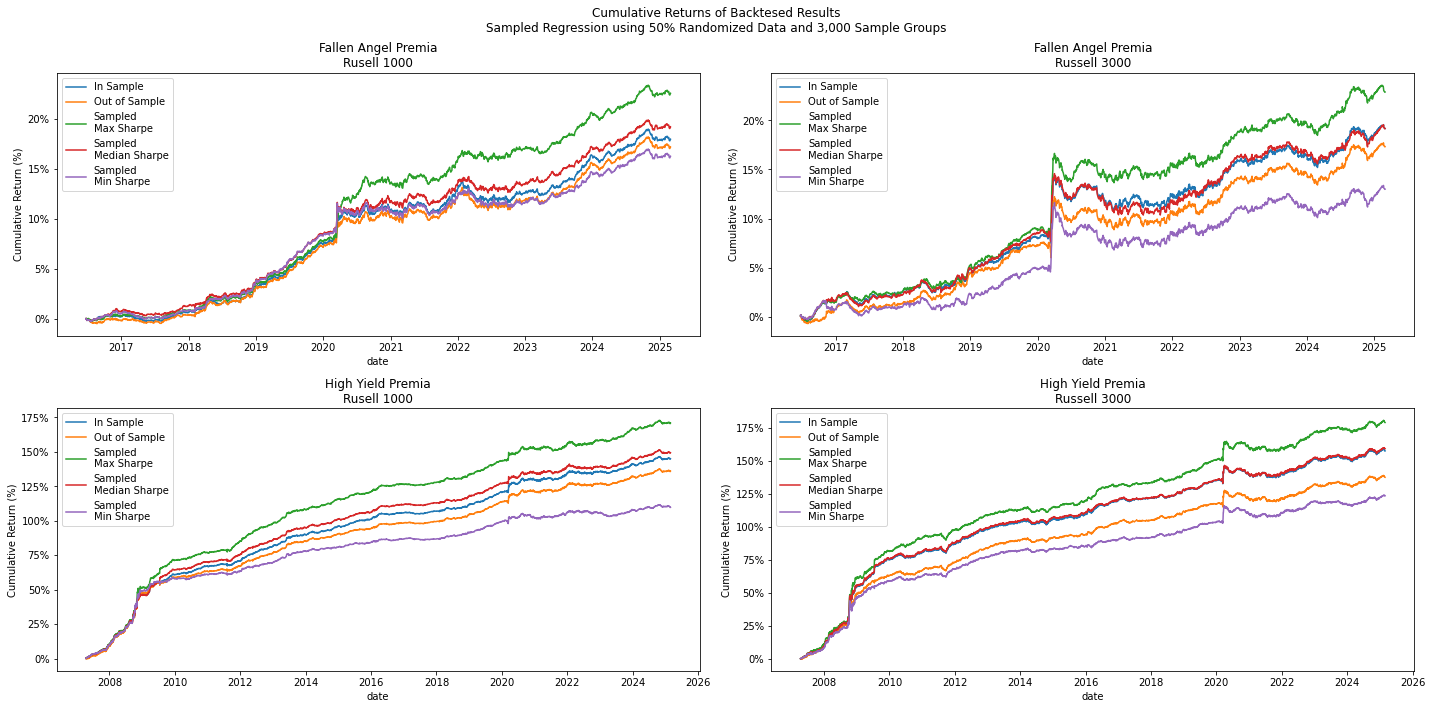

In [6]:
def plot_rtn(df_plot: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,10))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var").
            rename(columns = {"sample_group": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                ylabel = "Cumulative Return (%)",
                title  = group_var))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Cumulative Returns of Backtesed Results\nSampled Regression using 50% Randomized Data and 3,000 Sample Groups")
    plt.tight_layout()
    
plot_rtn(df_plot)

In [7]:
def get_sharpe(df_plot: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_plot[
        ["credit_premia", "eq_premia", "group_var", "sample_group", "signal_rtn"]].
        groupby(["credit_premia", "eq_premia", "group_var", "sample_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_sharpe(df_plot)

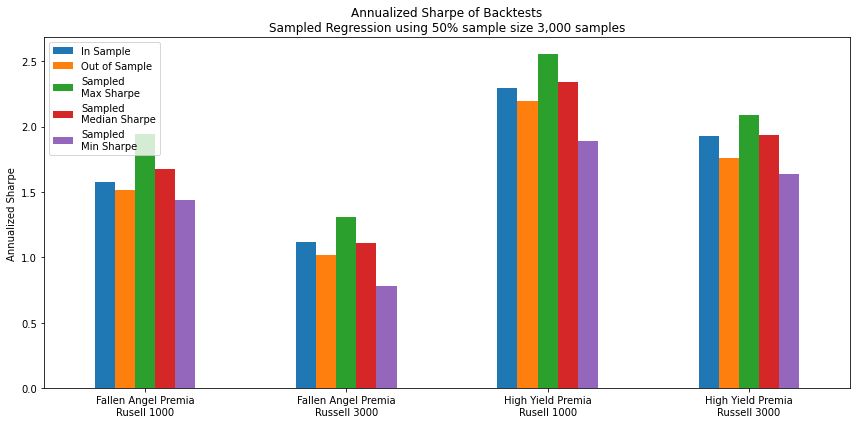

In [8]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe.assign(
        group_var = lambda x: x.credit_premia + "\n" + x.eq_premia).
        rename(columns = {"sample_group": ""}).
        pivot(index = "group_var", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            figsize = (12,6),
            rot     = 0,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of Backtests\nSampled Regression using 50% sample size 3,000 samples"))
    
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

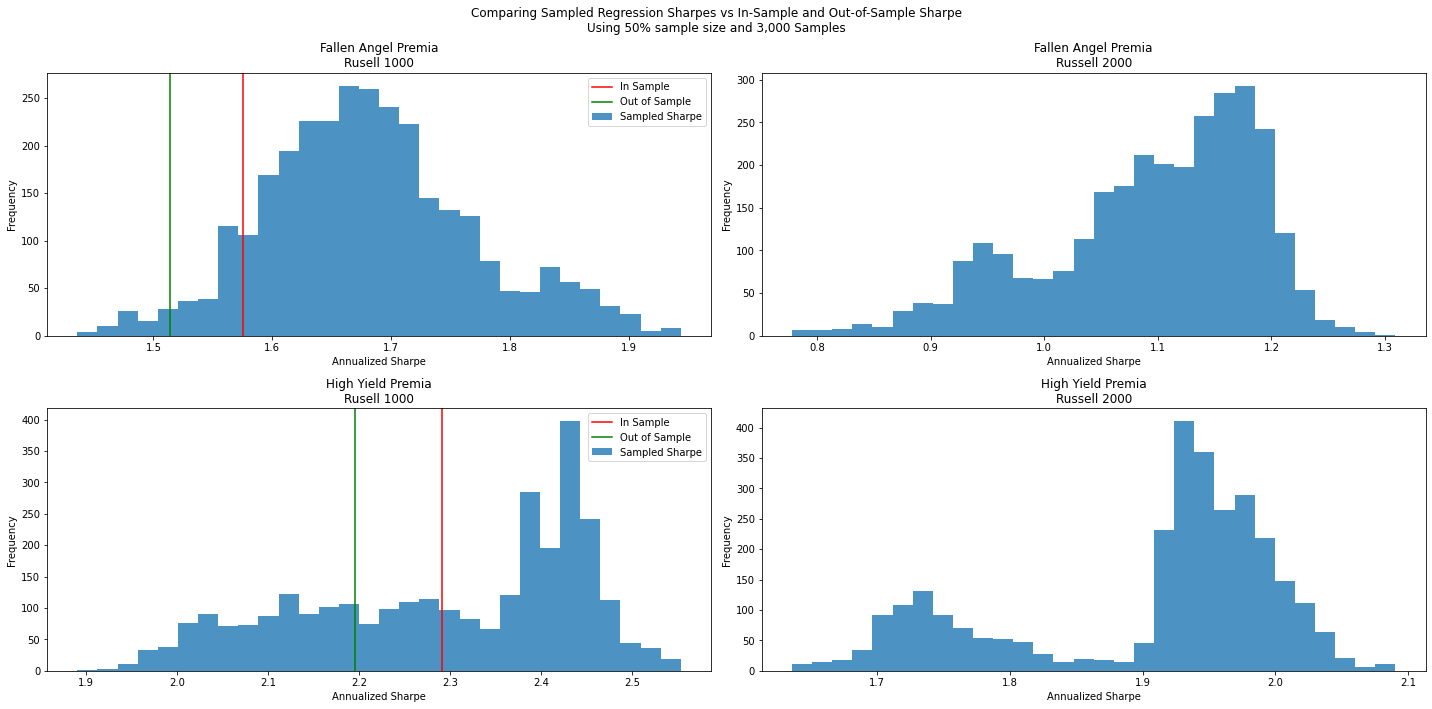

In [9]:
def plot_sharpe_distribution(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (SignalResid().get_sampled_sharpe().assign(
        credit_premia = lambda x: np.where(x.credit_premia == "fa_premia", "Fallen Angel Premia", "High Yield Premia"),
        eq_premia     = lambda x: np.where(x.eq_premia == "IWB", "Rusell 1000", "Russell 2000"),
        group_var     = lambda x: x.credit_premia + "\n" + x.eq_premia))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,10))

    colors = ["red", "green"]

    for group_var, ax in zip(group_vars, axes.flatten()):

        df_sharpe_tmp = (df_sharpe.query(
            "group_var == @group_var").
            query("sample_group == ['In Sample', 'Out of Sample']")
            [["sample_group", "sharpe"]].
            reset_index(drop = True))

        (df_tmp.query(
            "group_var == @group_var").
            rename(columns = {"sharpe": "Sampled Sharpe"})
            ["Sampled Sharpe"].
            plot(
                kind   = "hist",
                ax     = ax,
                bins   = 30,
                alpha  = 0.8,
                title  = group_var,
                xlabel = "Annualized Sharpe"))

        for i, row in df_sharpe_tmp.iterrows(): ax.axvline(x = row["sharpe"], label = row["sample_group"], color = colors[i]); ax.legend()

    fig.suptitle("Comparing Sampled Regression Sharpes vs In-Sample and Out-of-Sample Sharpe\nUsing 50% sample size and 3,000 Samples")
    plt.tight_layout()
    
plot_sharpe_distribution(df_sharpe)

# Portfolio Optimization

Equal Volatility Contribution results had the exact sharpe and return as equal weight so equal weight will be fine

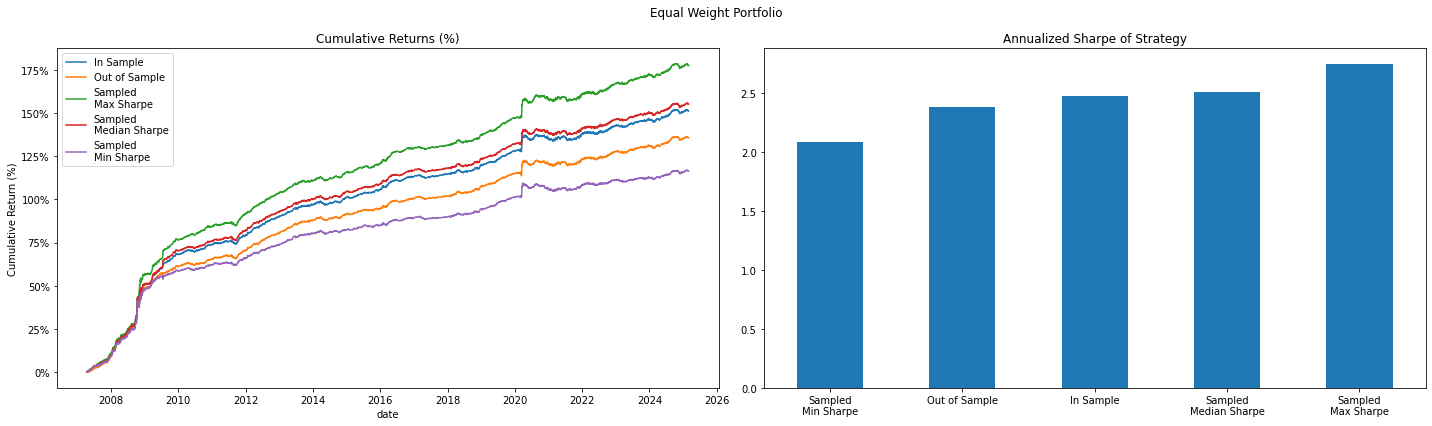

In [10]:
def plot_portfolio(df_plot: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_plot[
        ["sample_group", "signal_rtn", "date"]].
        groupby(["date", "sample_group"]).
        agg("mean").
        reset_index().
        rename(columns = {"sample_group": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[0],
            ylabel = "Cumulative Return (%)",
            title  = "Cumulative Returns (%)"))

    (df_plot[
        ["sample_group", "signal_rtn", "date"]].
        groupby(["date", "sample_group"]).
        agg("mean").
        reset_index().
        drop(columns = ["date"]).
        dropna().
        groupby("sample_group").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            kind   = "bar",
            ax     = axes[1],
            legend = False,
            title  = "Annualized Sharpe of Strategy",
            rot    = 0,
            xlabel = ""))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    fig.suptitle("Equal Weight Portfolio")
    plt.tight_layout()
    
plot_portfolio(df_plot)